#Implementação da arquitetura

In [ ]:
import tensorflow as tf
from tensorflow.keras import  Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K



In [ ]:
# Bloco convolucional utilizado em todas as etapas
def ConvBlock(tensor, num_feature):

  x = tf.keras.layers.Conv2D(num_feature, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(tensor)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Conv2D(num_feature, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  return x

def ponte(tensor, num_feature):
  x = ConvBlock(tensor,num_feature)
  return x

- verificar no artigo qual a melhor forma para inicializar os pesos
- num_feature: receberá um valor de num_features quando for chamado para compor a rede.
  - num_features = [16,32,64,125,256]
  - ainda n sei a melhor forma de fazer isso
preciso da saída do bloco, o pooling vai ser declarado fora dele.
- tensor:vetor (altura,largura,canais)

In [ ]:
# Seção encoder
def encoder_block(tensor, num_feature):
  x = ConvBlock(tensor, num_feature)
  p = tf.keras.layers.MaxPooling2D((2,2))(x)
  return x, p

#seção decoder
def decoder_block(tensor,skip_connection, num_feature):
  x = tf.keras.layers.Conv2DTranspose(num_feature, (2,2), strides=(2,2), padding='same')(tensor) #recebe do bloco anterior e faz upsampling
  x = tf.keras.layers.concatenate([x, skip_connection])
  x = ConvBlock(x, num_feature)
  return x


no encoder:
- retorna x sem pooling para a skip connection
- retorna p para o próximo bloco

no decoder:
- Concatenate: x e skip devem ter as mesmas dimensões-- *testar*
  - skip_connections vem do bloco convolucional simétrico (p)
- num_features é lido da lista invertida num_features (criar no pipeline)
- conv_block vai ter na entrada o dobro de mapas da contraparte simétrica(skip + transpose)

### estrutura da u-net

In [ ]:

def Unet(n_classes, tensor_shape):

  input = tf.keras.layers.Input(tensor_shape) #instancia o tensor para os dados de entrada

  #seção de contração:
  skip1, c1 = encoder_block(input,16) # 128x128x3 > 64x64x16
  skip2, c2 = encoder_block(c1,32) # 64x64x16 > 32x32x32
  skip3, c3 = encoder_block(c2,64) # 32x32x32 > 16x16x64
  skip4, c4 = encoder_block(c3,128) # 16x16x64 > 8x8x64

  #bottleneck
  c5 = ponte(c4,256) # 8x8x64 > 8x8x256

  #seção de expansão:
  c6 = decoder_block(c5, skip4, 128) #8x8x256 > 16x16x128
  c7 = decoder_block(c6, skip3, 64) #16x16x128 > 32x32x64
  c8 = decoder_block(c7, skip2, 32) #32x32x64 > 64x64x32
  c9 = decoder_block(c8, skip1, 16) #64x64x32 > 128x128x16

  #camada de saída:
  output = tf.keras.layers.Conv2D(n_classes, (1,1), activation='softmax')(c9) #128x128x16 > 128x128x8, 8= número de classes

  model = Model(input, output, name="U-Net")
  return model


Na saída:
- meu problema é multiclasse, como codificar os rótulos de cor rgb para as classes? dps vejo

### compilando

In [ ]:
from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.

    Ref: https://en.wikipedia.org/wiki/Jaccard_index

    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


# Test and plot
y_pred = np.array([np.arange(-10, 10+0.1, 0.1)]).T
y_true = np.zeros(y_pred.shape)
name='jaccard_distance_loss'
try:
    loss = jaccard_distance_loss(
        K.variable(y_true),K.variable(y_pred)
    ).eval(session=K.get_session())
except Exception as e:
    print("error plotting", name ,e)
else:
    plt.title(name)
    plt.plot(y_pred,loss)
    plt.show()

# Test
# Test
print("TYPE                 |Almost_right |half right |all_wrong")
y_true = np.array([[0,0,1,0],[0,0,1,0],[0,0,1.,0.]])
y_pred = np.array([[0,0,0.9,0],[0,0,0.1,0],[1,1,0.1,1.]])

r = jaccard_distance_loss(
    K.variable(y_true),
    K.variable(y_pred),
).eval(session=K.get_session())
print('jaccard_distance_loss',r)
assert r[0]<r[1]
assert r[1]<r[2]

r = keras.losses.binary_crossentropy(
    K.variable(y_true),
    K.variable(y_pred),
).eval(session=K.get_session())
print('binary_crossentropy',r)
print('binary_crossentropy_scaled',r/r.max())
assert r[0]<r[1]
assert r[1]<r[2]

"""
TYPE                 |Almost_right |half right |all_wrong
jaccard_distance_loss [ 0.09900928  0.89108944  3.75000238]
binary_crossentropy [  0.02634021   0.57564634  12.53243446]
binary_crossentropy_scaled [ 0.00210176  0.04593252  1.        ]
"""

In [ ]:
#parâmetros:
input_shape = (256,256, 1)
num_classes = 9
lr = 0.003
#metrics = ["accuracy",MeanIoU(num_classes=num_classes)]
metrics = ["accuracy"]

loss =  SparseCategoricalCrossentropy()
#loss = 'categorical_crossentropy'

model = Unet(num_classes, input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=metrics)
model.summary()

arquivo_modelo = '' # .h não é mais aceito
arquivo_modelo_json = ''

#Callbacks
lr_reducer = ReduceLROnPlateau( monitor='val_loss', factor = 0.9, patience = 3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 15, verbose = 1, mode='auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor = 'val_loss', verbose = 1, save_best_only=True)

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 16)   │            160 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 256, 256, 16)   │             64 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 256, 256, 16)   │             64 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128, 128, 32)   │            128 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 128, 128, 32)   │            128 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 32)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 64, 64, 64)     │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout) 

 Total params: 1,946,841 (7.43 MB)

 Trainable params: 1,943,897 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

!!! Alterar a função de perda e a métrica para os métodos apropriados depois de lidar com os dados e o restante do código

In [ ]:
#testando o modelo
import numpy as np

input_image = np.random.rand(1, 256, 256, 1)
output_image = model.predict(input_image)

input_shape = input_image.shape
output_shape = output_image.shape

print("Dimensão da entrada:", input_shape)
print("Dimensão da saída:", output_shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Dimensão da entrada: (1, 256, 256, 1)
Dimensão da saída: (1, 256, 256, 9)


# Pré Processamento

In [ ]:
#bibliotecas
import tensorflow as tf
import keras
import os
import re
import sys
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical



In [ ]:
# caminhos para os diretórios das imagens
#real_img_treino = "/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Dataset_UltrassomAbdominal/abdominal_US/abdominal_US/RUS/images/train"
# não tem mascara de treino pra ultrasons reais
sim_img_treino = "/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Dataset_UltrassomAbdominal/abdominal_US/abdominal_US/AUS/images/train"
sim_mask_treino = "/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Dataset_UltrassomAbdominal/abdominal_US/abdominal_US/AUS/annotations/train"

#real_img_val = "/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Dataset_UltrassomAbdominal/abdominal_US/abdominal_US/RUS/images/test"
#real_mask_val = "/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Dataset_UltrassomAbdominal/abdominal_US/abdominal_US/RUS/annotations/test"
sim_img_val = "/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Dataset_UltrassomAbdominal/abdominal_US/abdominal_US/AUS/images/test"
sim_mask_val = "/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Dataset_UltrassomAbdominal/abdominal_US/abdominal_US/AUS/annotations/test"


Não vou usar as imagens reais para os primeiros testes de treinameto até descobrir como ajustar a correspondência entre máscaras e imagens

##Dataloader

In [ ]:
"""esta função segmenta o nome do arquivo para o img_loader ordenar o dataset
na ordem do diretório e ter correspondência entre a lista de imagens e máscaras"""

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

""" img_loader recebe um caminho de diretório,uma lista vazia e  uma tupla com
dimensões de imagem. Lê as imagens png ou jpg do diretório, ordena pelo nome e
 armazena a imagem na lista img_data e seu nome na lista img_names"""
def img_loader(path, img_data, size=None, rgb=True):
  #lista para o nome dos arquivos
  img_names = []

  for diretorio_path in sorted(glob.glob(path)):
    for img_path in sorted(glob.glob(os.path.join(diretorio_path, "*.[pj]*[np]*[g]*")), key=natural_sort_key): #percorre o diretório na ordem natural dos títulos de arquivo
      img = cv2.imread(img_path,
                       cv2.IMREAD_COLOR if rgb
                       else cv2.IMREAD_GRAYSCALE) #img tem 3 canais na 3 dimensao se RGB, e 1 canal se preto/branco

      if rgb:  # Corrige para formato RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      if size is not None:
        img = cv2.resize(img, size) #redimensiona conforme o parâmetro

      img_data.append(img.astype(np.uint8)) #add a imagem na lista do parametro
      img_names.append(os.path.basename(img_path)) #add o nome do arquivo na lista de nomes

  #return img_data, img_names
  return np.array(img_data), img_names

- As imagens reais e simuladas tem dimensões diferentes, dataloader inclui a função de redimensionamento
  - preciso cortar? talvez..
- img_loader tbm converte as imagens para rbg ou escala de cinza
 - necessário pois as máscaras são rgb e seus arrays tem que ser do formato (h,w,3)

###Listas np.array com as imagens e máscaras

In [ ]:
#conjuntos de treino
  #imagens simuladas
Simg_treino = []
Simg_treino_names = []
Smask_treino = []
Smask_treino_names = []
  #imagens reais
"""Rimg_treino = []
Rimg_treino_names = []
#ñ tem mascara real p teste"""

#conjuntos de teste
  #imagens simuladas
Simg_val = []
Simg_val_names = []
Smask_val = []
Smask_val_names = []

  #imagens reais
"""Rimg_val = []
Rimg_val_names = []
Rmask_val = []
Rmask_val_names = []"""


'Rimg_val = []\nRimg_val_names = []\nRmask_val = []\nRmask_val_names = []'

In [ ]:
#Carregando os dados:

dim = (256,256)
Simg_treino, Simg_treino_names = img_loader(sim_img_treino, Simg_treino,dim, False)
Smask_treino, Smask_treino_names = img_loader(sim_mask_treino,Smask_treino,dim)
#Rimg_treino, Rimg_treino_names = img_loader(real_img_treino,Rimg_treino,None,False)

Simg_val, Simg_val_names = img_loader(sim_img_val, Simg_val,dim, False)
Smask_val, Smask_val_names = img_loader(sim_mask_val,Smask_val,dim)
#Rimg_val, Rimg_val_names = img_loader(real_img_val, Rimg_val,None,False)
#Rmask_val, Rmask_val_names = img_loader(real_mask_val,Rmask_val)


As listas com nomes dos arquivos serviram para eu consertar a ordem de armazenamento das imagens e garantir a correspondência com as máscaras

###Verificando os dados

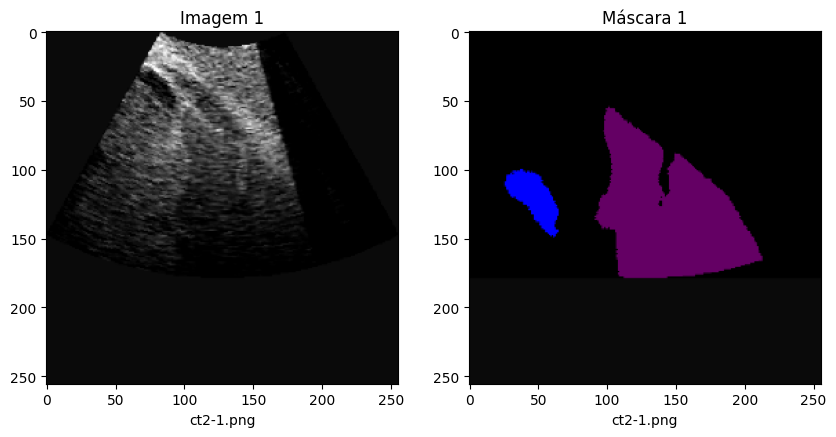

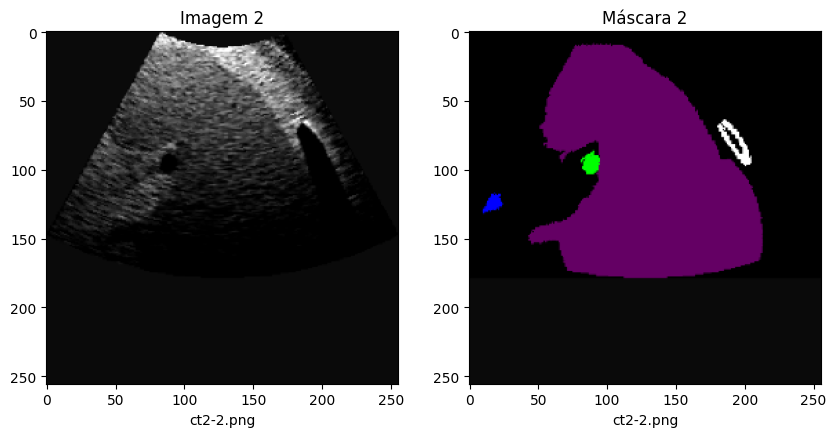

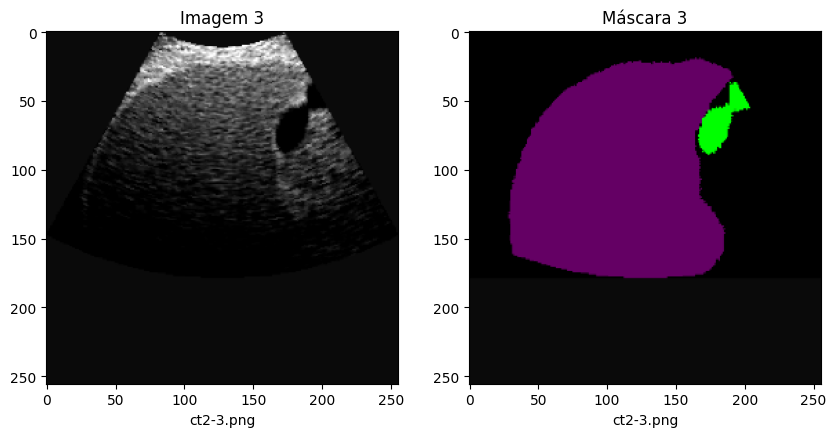

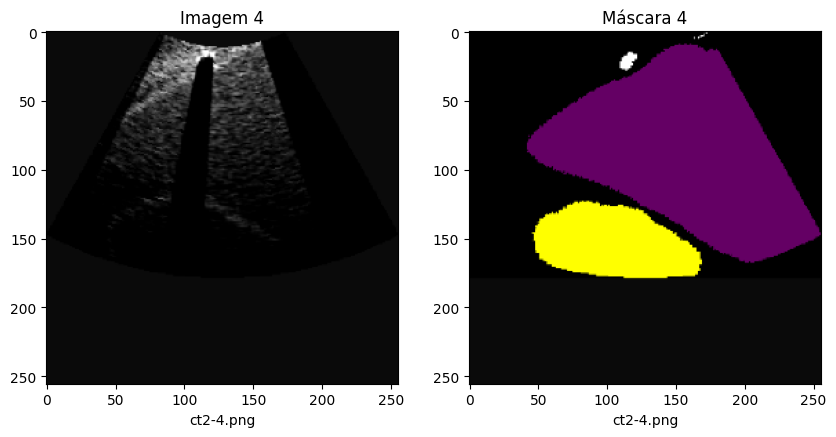

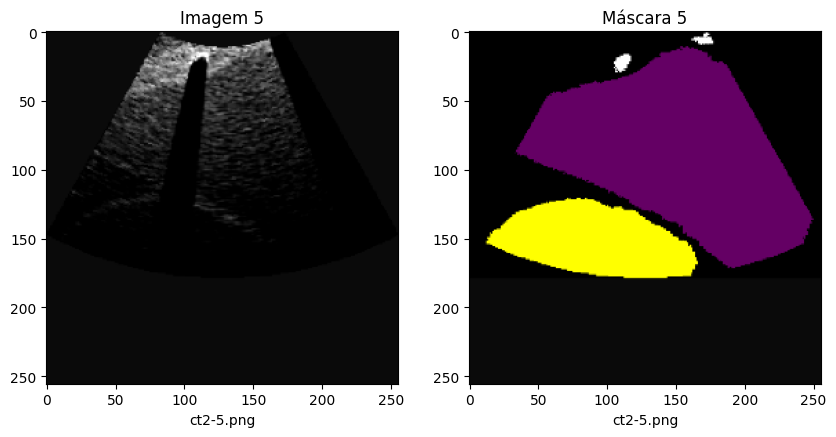

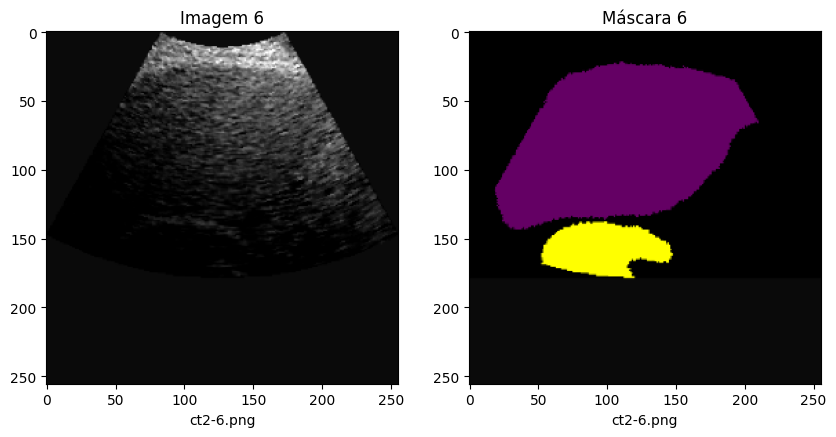

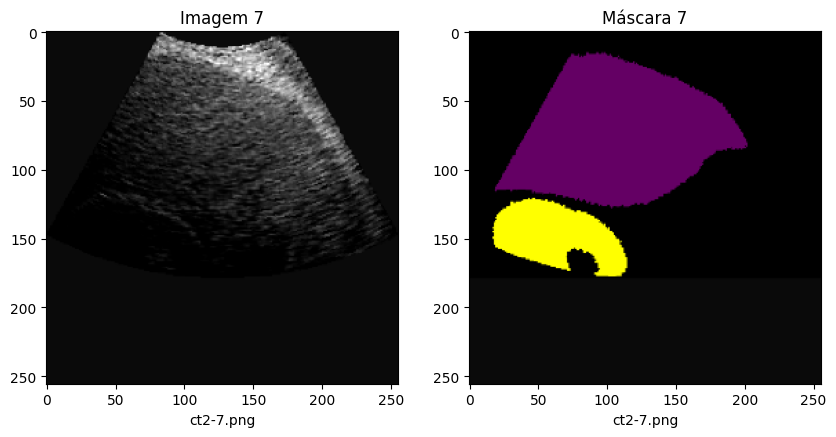

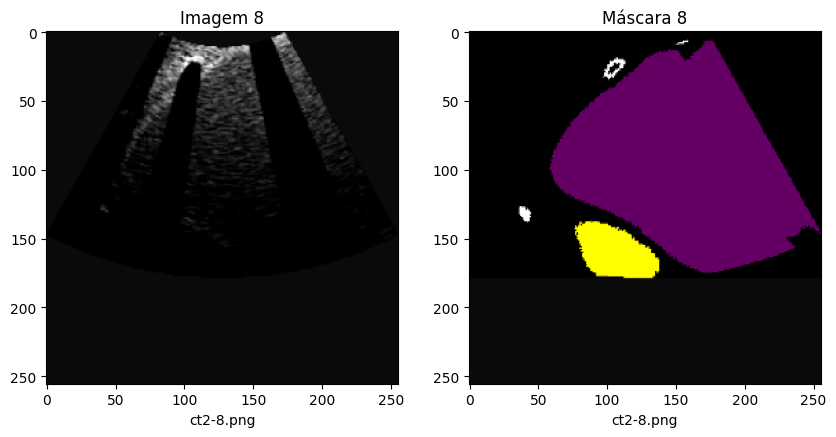

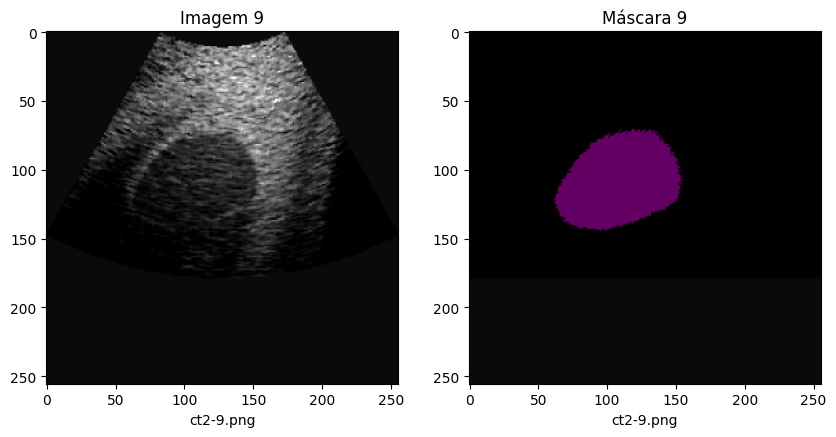

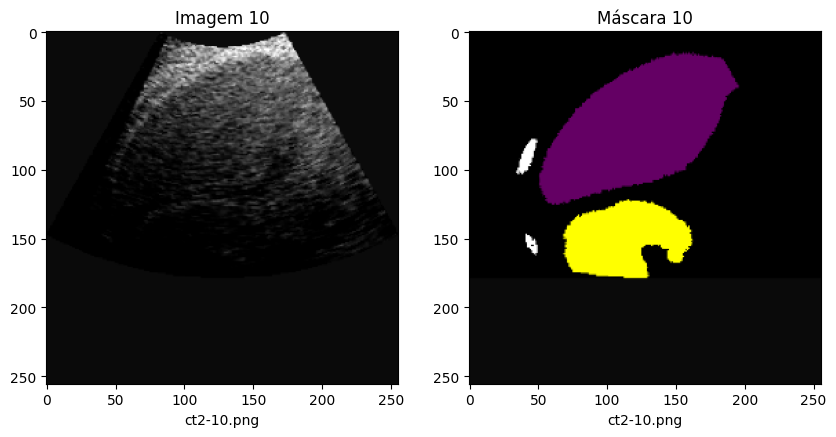

In [ ]:
#Verificando algumas imagens
for i in range(10):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(Simg_treino[i], cmap='gray')
    plt.title(f"Imagem {i + 1}")
    plt.xlabel(Simg_treino_names[i])

    plt.subplot(1,2,2)
    plt.imshow(Smask_treino[i], cmap='gray')
    plt.title(f"Máscara {i + 1}")
    plt.xlabel(Smask_treino_names[i])

    plt.show()

NameError: name 'Rimg_val' is not defined

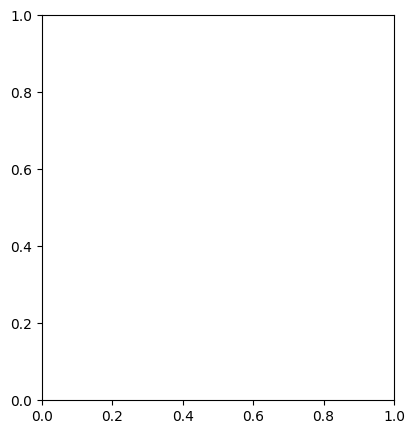

In [ ]:
for i in range(10):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(Rimg_val[i], cmap='gray')
    plt.title(f"Imagem {i + 1}")
    plt.xlabel(Rimg_val_names[i])

    plt.subplot(1,2,2)
    plt.imshow(Rmask_val[i], cmap='gray')
    plt.title(f"Máscara {i + 1}")
    plt.xlabel(Rmask_val_names[i])

    plt.show()

 **PROBLEMA, TRETA**
- A quantide de máscaras e imagens de US reais não batem,tem apenas 63 máscaras de validação para 213 imagens.
- Não há NENHUMA máscara para as imagens de treinamento.

Não seria um problema ter apenas 63 máscaras de validação mas >> **as máscaras também não correspondem às imagens com o mesmo índice/numeração!!** << Vou ter que compara uma a uma ??? talvez nem de pra usar mais.

As imagens de US simulados tem uma qualidade muito inferior às reais, e não sei o quão bem o modelo conseguirá generalizar para elas, se eu não as incluir no treinamento, nem sei se é bom misturar os dois. Opções:

  (supondo que resolvi as correspondências):

   1. Dividir as 63 reais em treino/validação e igualar à qtde de simuladas usando augmentation.

   2. Igualar a qtde de imagens do dataset simulado às reais(reduzindo), e depois passando pelo augmentaton.

   3. Treinar o modelo somente com as simuladas e utilizar *transfer learning* para treinar o modelo em imagens reais.

## Funções para processar as máscaras e tensor de saída

**Dicionário RGB > Rótulo**

In [ ]:
def gen_dict_cores():
    mask_dict = {
        (0, 0, 0): 0,        # Preto = None
        (100, 0, 100): 1,    # Violeta = Liver (fígado)
        (255, 255, 255): 2,  # Branco = Bone (Osso)
        (0, 255, 0): 3,      # Verde = Gallbladder (Vesícula biliar)
        (255, 255, 0): 4,    # Amarelo = Kidney (Rins)
        (0, 0, 255): 5,      # Azul = Pancreas
        (255, 0, 0): 6,      # Vermelho = Vessels (Veias)
        (255, 0, 255): 7,    # Rosa = Spleen (Baço)
        (0, 255, 255): 8     # Azul claro = Adrenal (Glândula Adrenal)
    }
    return mask_dict

As imagens estão armazenadas em arrays Numpy. Como converter os valores RGB de cada canal, em cada pixel, para tupla? ou refaço o dicionário para arrays?


**Conversor Matriz RGB > Matriz de Rótulos**

In [ ]:
""" Função que mapeia cada pixel da imagem ao valor rgb definido no dicionário,
 e substitui o valor pelo rótulo correspondente, em um novo array."""

def RGBtoClass(rgb, dictCores):
    arr = np.zeros(rgb.shape[:2])  # Inicializa a matriz de rótulos

    for color, label in dictCores.items():  # Itera sobre os pares (cor, rótulo)
        color = np.array(color)  # Converte a cor para um array NumPy
        arr[np.all(rgb == color, axis=-1)] = label  # Atribui o rótulo aos pixels que correspondem à cor

    return arr


- Tentei implementar na mão com outra função em loops aninhados, mas a função **np.all** é muito mais eficiente pois faz uma operação matricial
- Converter a tupla para np.array deve garantir a comparação correta sem ter de alterar o dicionário

**Conversor Saída One-Hot > Matriz RGB**
A saída de um modelo de segmentação geralmente é da forma [batch_size, n_classes, altura, largura]. n_classes é um *one hot vector*, para um dado índice de pixel, com tamanho n-classes. A função softmax define uma probabilidade para cada classe, e a maior é tida como a cor correspondente ao pixel.

In [ ]:
def onehot_to_rgb(oneHot, dictCores):
    oneHot = np.array(oneHot)  # Converte para array numpy
    oneHot = np.argmax(oneHot, axis=-1)  # Seleciona o maior valor (índice)
    output = np.zeros(oneHot.shape + (3,))  # Cria a matriz RGB de saída
    oneHot = np.expand_dims(oneHot, axis=-1)  # Expande as dimensões

    for color, index in dictCores.items():
        output[np.all(oneHot == index, axis=-1)] = color

    return np.uint8(output)

1.  one-hot deve ser: (1, height, width, classes)
2.  argmax retorna o maior valor na dimensao classes.  (1, height, width), cada posição contém o índice da classe com maior probabilidade. para cada pixel
3. np.zeros cria uma matriz de saída com as dimensões e one-hot(imagem de saída), e adiciona +1dim de 3 canais para as cores.
4. Itera sobre o dicionário comparando os pixels de onehot com a chave do dicionário. Havendo correspondência, o pixel reve o valor RBG na matriz de saída.
5. Converte a saída para uint8, deixando os valores rgb no intervalo 0-255


####Testando as funções de conversão

**Testando conversão de RGB > OneHot**

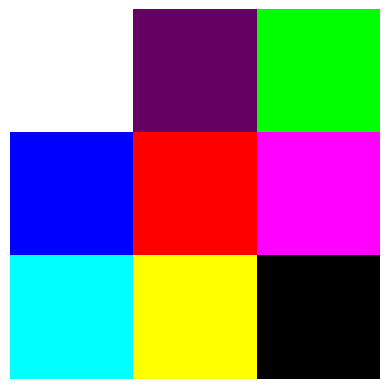

Matriz de rótulos (one-hot):
[[2. 1. 3.]
 [5. 6. 7.]
 [8. 4. 0.]]


In [ ]:
# Criando uma imagem RGB 3x3 com as cores do dicionário
rgb_image = np.array([
    [(255, 255, 255), (100, 0, 100), (0, 255, 0)],
    [(0, 0, 255), (255, 0, 0), (255, 0, 255)],
    [(0, 255, 255), (255, 255, 0), (0, 0, 0)]
])

dictCores = gen_dict_cores()

# gerando o matriz de rotulos
one_hot_image = RGBtoClass(rgb_image, dictCores)

# Exibindo a imagem RGB gerada
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

# Exibindo a matriz de rótulos
print("Matriz de rótulos:")
print(one_hot_image)

A função funciona bem. testando com uma imagem real:

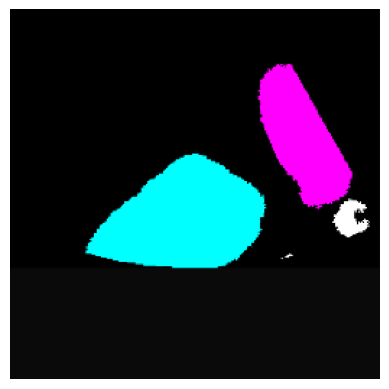

Matriz de rótulos (one-hot):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [ ]:
one_hot_image = RGBtoClass(Smask_treino[50], dictCores)
np.set_printoptions(threshold=np.inf)

# Exibindo a imagem RGB gerada
plt.imshow(Smask_treino[50])
plt.axis('off')
plt.show()

# Exibindo a matriz de rótulos (one-hot)
print("Matriz de rótulos (one-hot):")
print(np.array_str(one_hot_image))

O vetor one-hot de saída funcionou, há apenas os índices das cores que aparecem na imagem: azul(7), rosa(8), e branco(2)

**Saída do modelo:**
Teste com uma imagem 4x4 para verificar a conversão dos pixels para
as classes correspondentes

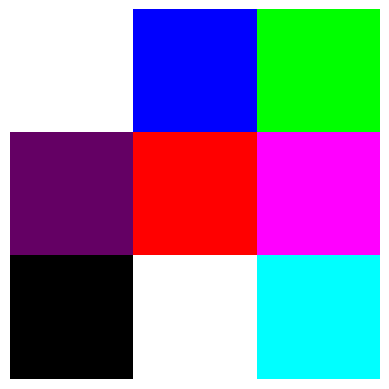

Dimensão da saída do modelo: (3, 3, 9)
Dimensão da imagem RGB gerada: (3, 3, 3)


In [ ]:
# Definindo manualmente as classes para cada pixel da imagem 3x3
oneHot = np.zeros((3, 3, 9))  # Imagem 3x3 com 9 classes

# One-hot com as classes do dicionário:

#esse resultado explicito quem o faz é o argmax
oneHot[0, 0, 2] = 1  # Branco (Osso) (0,0)
oneHot[0, 1, 5] = 1  # Azul (Pancreas) (0,1)
oneHot[0, 2, 3] = 1  # Verde (Vesícula) (0,2)

oneHot[1, 0, 1] = 1  # Violeta (Fígado) (1,0)
oneHot[1, 1, 6] = 1  # Vermelho (Veias) (1,1)
oneHot[1, 2, 7] = 1  # Rosa (Baço) (1,2)

oneHot[2, 0, 0] = 1  # Preto (Nada) (2,0)
oneHot[2, 1, 2] = 1  # Branco (Osso) (2,1)
oneHot[2, 2, 8] = 1  # Azul claro (Gland.Adrenal) (2,2)

# Gerando o dicionário
dictCores = gen_dict_cores()

# Convertendo o vetor one-hot para a imagem RGB
rgb_image = onehot_to_rgb(oneHot, dictCores)


plt.imshow(rgb_image)
plt.axis('off')
plt.show()
print("Dimensão da saída do modelo:", oneHot.shape)
print("Dimensão da imagem RGB gerada:", rgb_image.shape)

**Teste One-hot > RGB**

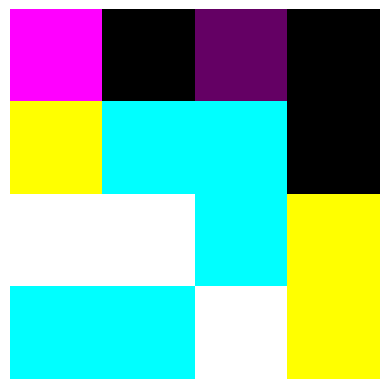

Dimensão da saída do modelo: (4, 4, 9)
Dimensão da imagem RGB gerada: (4, 4, 3)
[[[0.57908881 0.33580392 0.34410017 0.23720563 0.13586635 0.05622759
   0.5862357  0.96747813 0.45280148]
  [0.8930983  0.18276845 0.62709657 0.07603959 0.67300906 0.67327464
   0.61237694 0.21165752 0.22208691]
  [0.22039128 0.94177474 0.33338415 0.51746079 0.59490881 0.01584007
   0.66245684 0.42296073 0.67942008]
  [0.93072832 0.47512061 0.56555351 0.00935921 0.76246471 0.24776436
   0.67333821 0.60336891 0.57013791]]

 [[0.67547263 0.97666166 0.48209579 0.05390186 0.98060942 0.56406069
   0.31010073 0.61860062 0.00416096]
  [0.67526767 0.77943618 0.5162135  0.08672409 0.32712662 0.58154258
   0.67918167 0.38743725 0.85377961]
  [0.10333022 0.33368111 0.2277703  0.36395461 0.17047299 0.31021793
   0.13229725 0.23419578 0.77836624]
  [0.93419304 0.82677624 0.41762912 0.72430383 0.60024323 0.73791163
   0.30090767 0.87661449 0.28460251]]

 [[0.54004565 0.31069832 0.91982634 0.50408192 0.86804815 0.66417395

In [ ]:
output_image = np.random.rand(1, 4, 4, 9)  # Imagem de saída com 9 classes
output_image = np.squeeze(output_image, axis=0)  # Remove a dimensão do batch(so tem uma img)

# Criando o dicionário
dictCores = gen_dict_cores()

# Convertendo a saída do modelo para a imagem RGB
rgb_image = onehot_to_rgb(output_image, dictCores)

# Imagem gerada
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

print("Dimensão da saída do modelo:", output_image.shape)
print("Dimensão da imagem RGB gerada:", rgb_image.shape)
print(output_image)

A função funciona MUITO bem :)

# Carregando dados

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

**Carregando dados**

In [ ]:
'''concatenando as imagens e mascaras de treino / teste para separar ao carregar
no  train_test_split'''
all_imgs = np.concatenate((Simg_treino, Simg_val), axis=0)
all_masks = np.concatenate((Smask_treino, Smask_val), axis=0)

all_imgname = Simg_treino_names + Simg_val_names
all_maskname = Smask_treino_names + Smask_val_names

all_imgs  = np.expand_dims(all_imgs, axis=3)
all_imgs.shape, all_masks.shape

((926, 256, 256, 1), (926, 256, 256, 3))

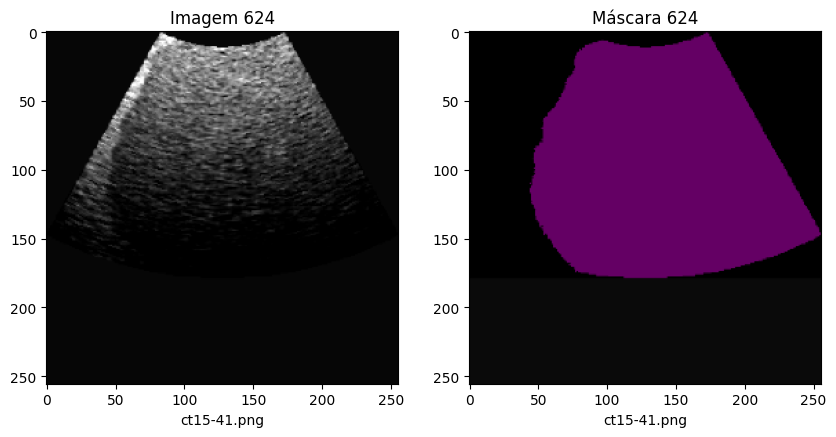

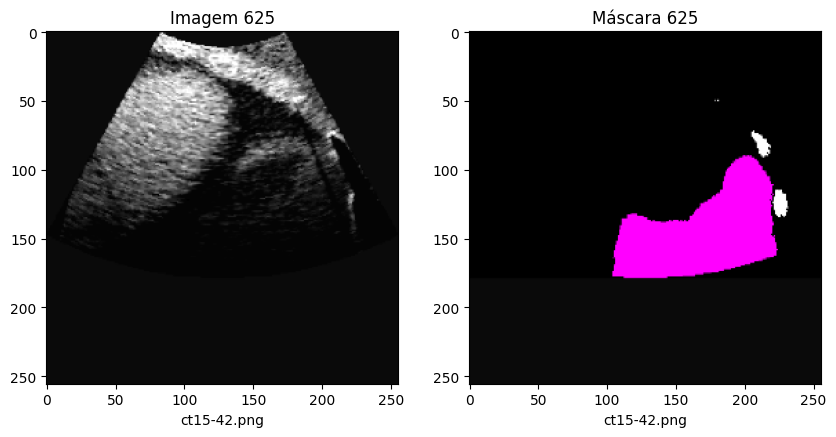

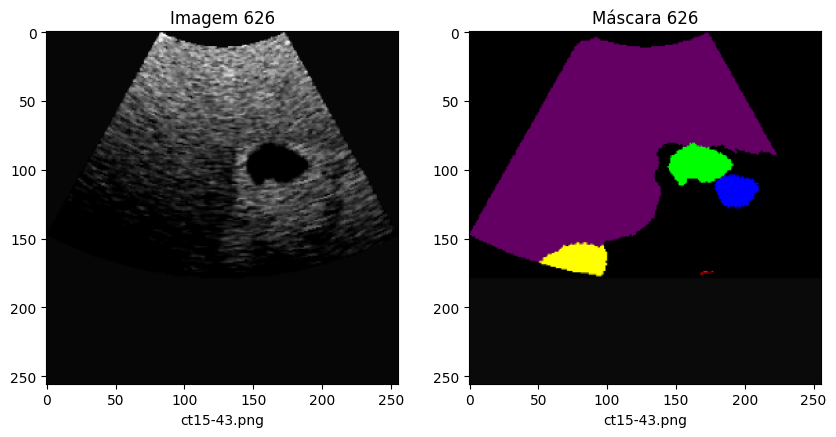

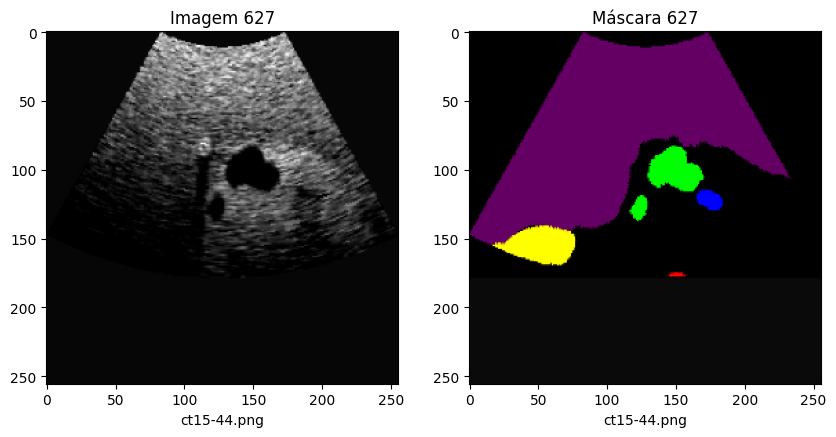

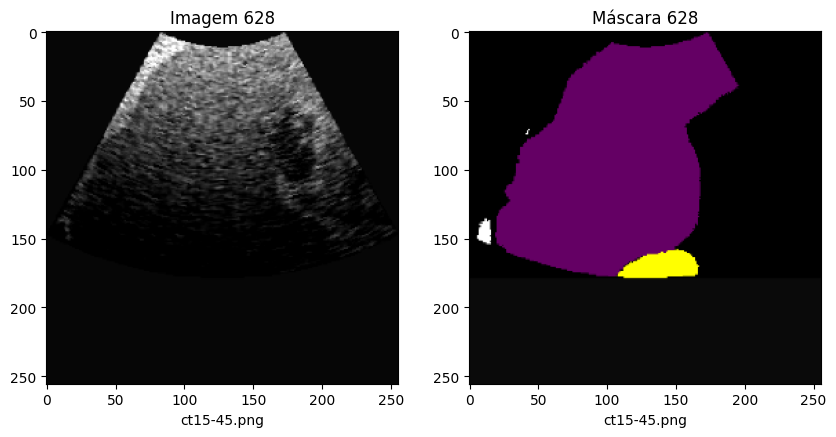

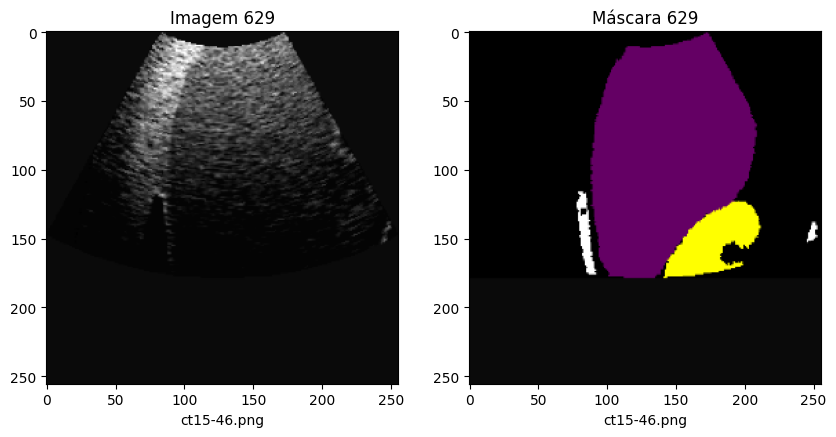

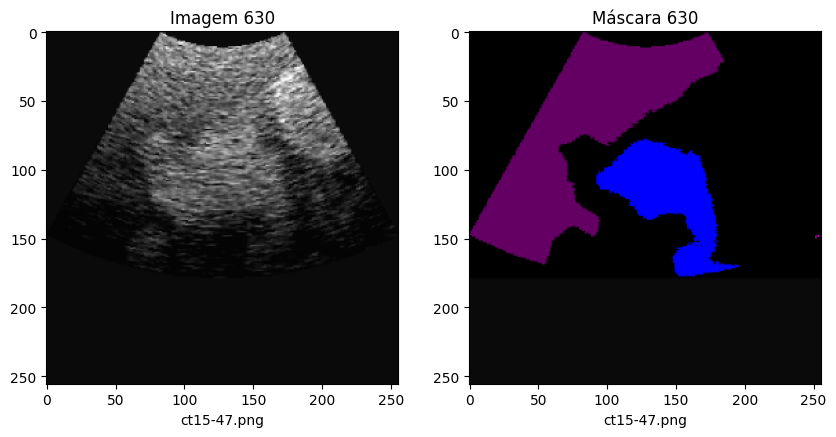

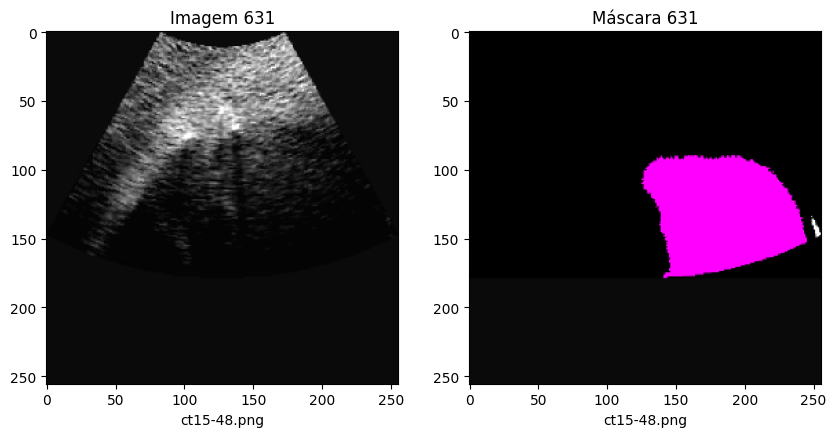

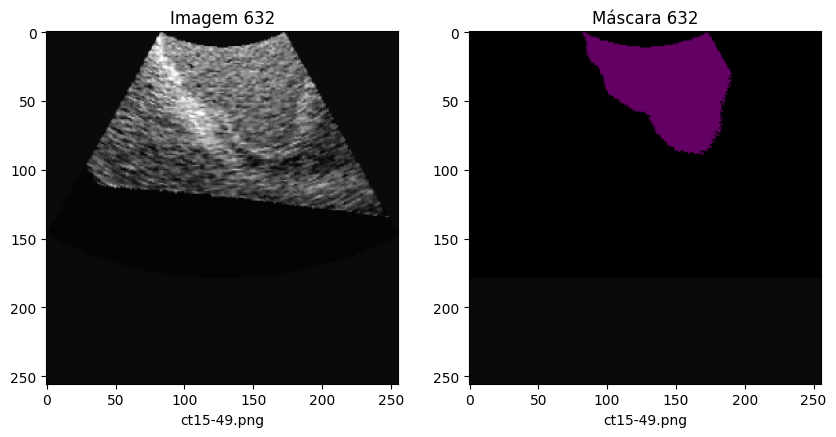

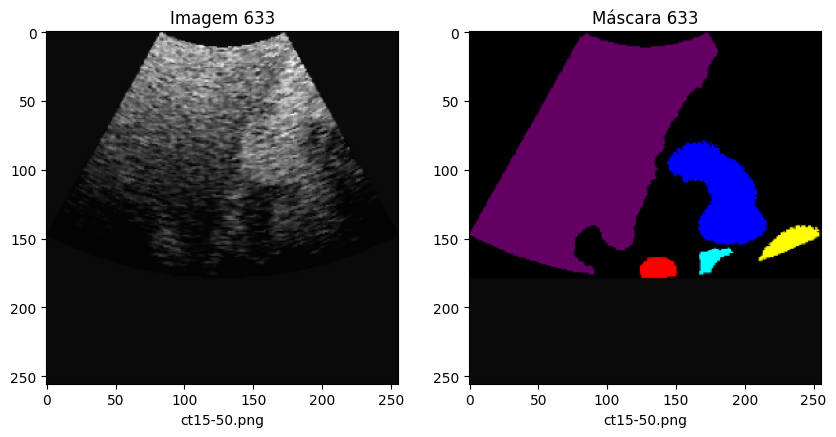

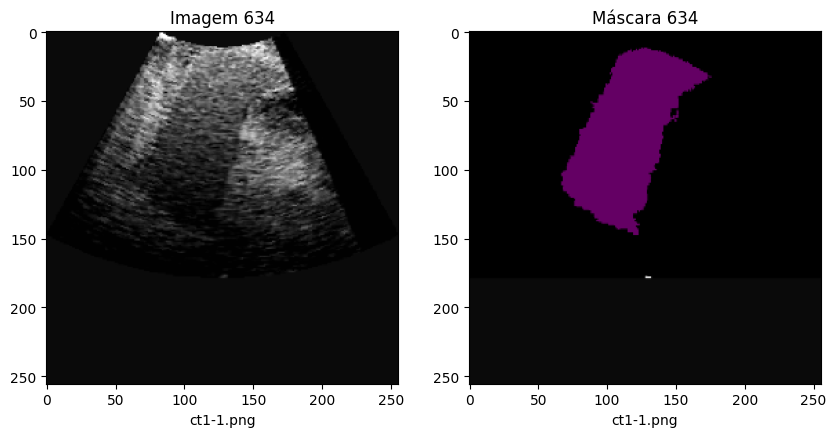

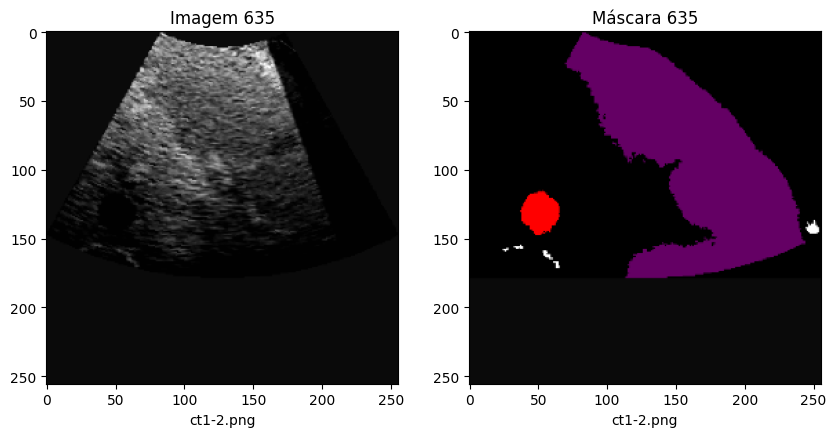

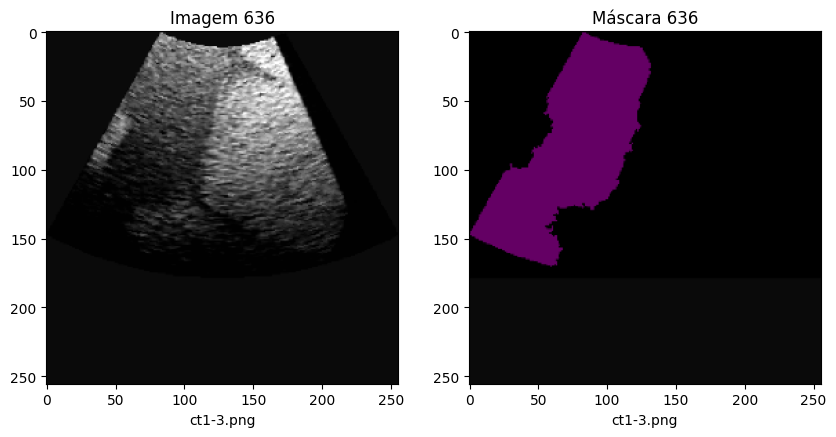

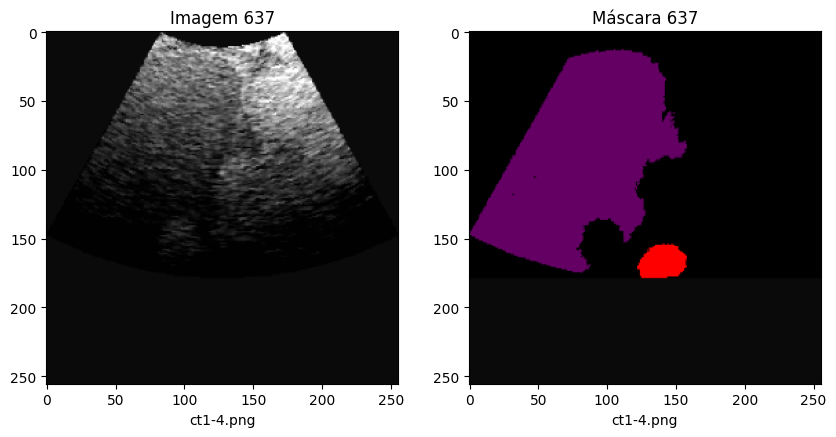

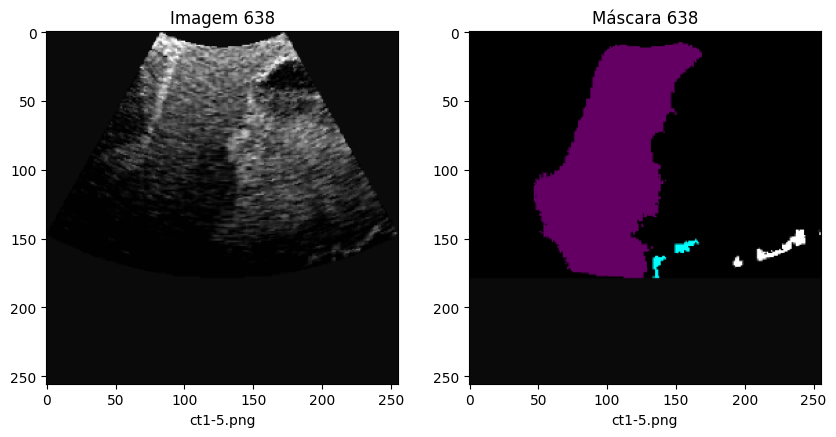

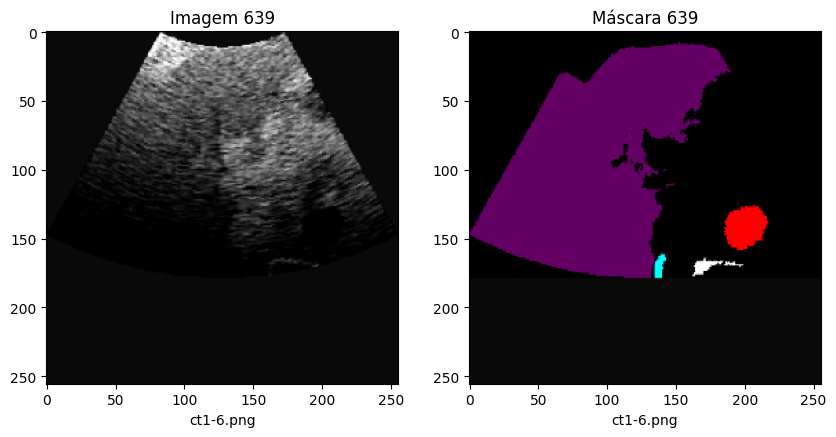

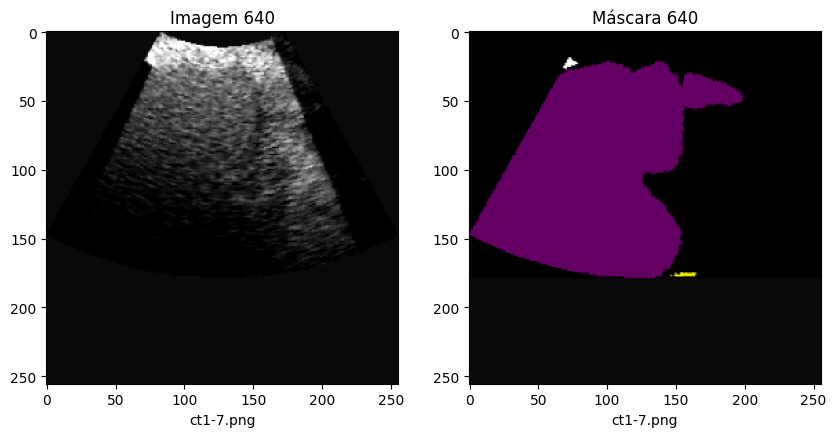

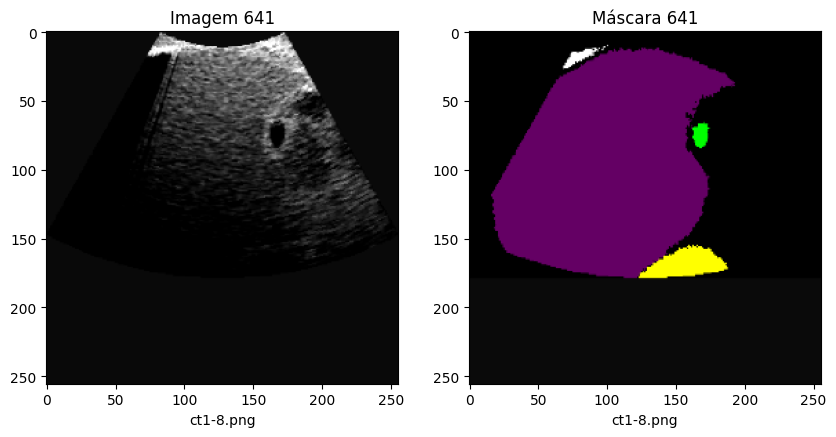

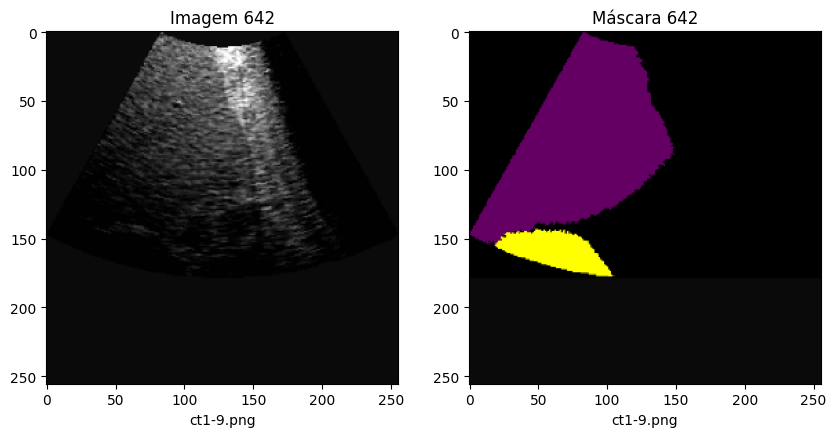

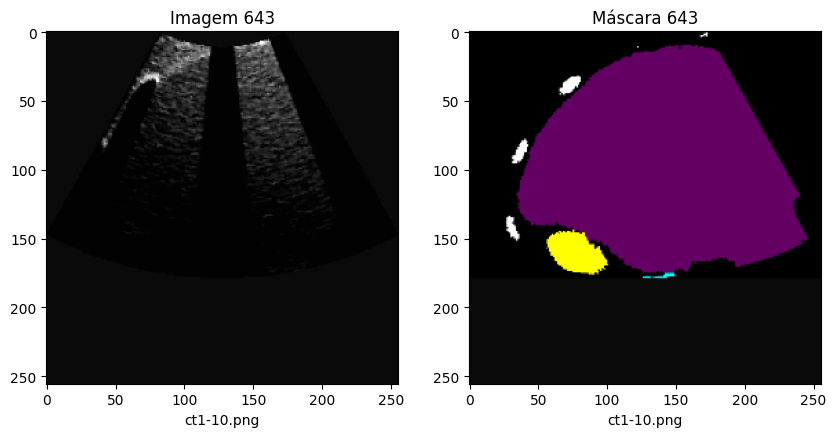

In [ ]:
for i in range(20):
    plt.figure(figsize=(10, 5))

    # Exibindo imagem
    plt.subplot(1, 2, 1)
    plt.imshow(all_imgs[i + 623], cmap='gray')
    plt.title(f"Imagem {i + 624}")
    plt.xlabel(all_imgname[i + 623])

    # Exibindo máscara
    plt.subplot(1, 2, 2)
    plt.imshow(all_masks[i + 623], cmap='gray')
    plt.title(f"Máscara {i + 624}")
    plt.xlabel(all_maskname[i + 623])

    plt.show()

td certo por aqui

In [ ]:
dictCores = gen_dict_cores()
#all_img_class = [] #as imagens não precisam ser convertidas para índices de classe/pixel
all_mask_class = []

"""for image in  all_imgs:
    #img_all = np.expand_dims(img_all, axis=3)
    onehotimage = RGBtoOneHot(image, dictCores)
    all_img_class.append(onehotimage)"""

for mask in  all_masks:
    onehotmask = RGBtoClass(mask, dictCores)
    all_mask_class.append(onehotmask)

#convertendo de volta para np.array
#train_img = np.array(all_img_class)
all_mask_class = np.array(all_mask_class)

#expandindo 1 dimensão
#train_img_all = np.expand_dims(all_img_class, axis=3)
all_mask_class = np.expand_dims(all_mask_class, axis=3)

#print("Classes únicas nos pixels das imagens :", np.unique(all_img_class))
print("Classes únicas nos pixels das  máscaras :", np.unique(all_mask_class), all_mask_class.shape)
#print("Formato das imagens :", all_img_class.shape)


Classes únicas nos pixels das  máscaras : [0. 1. 2. 3. 4. 5. 6. 7. 8.] (926, 256, 256, 1)


Isso confirma que todas as classes presentes nas máscaras foram mapeadas corretamente

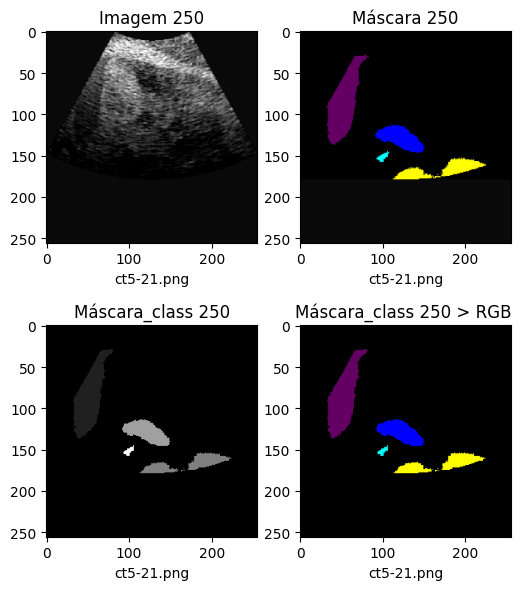

((256, 256, 1), (256, 256, 3), (256, 256, 1), (256, 256, 3))

In [ ]:
plt.figure(figsize=(6, 7))

idx = 250
# imagem
plt.subplot(2, 2, 1)
plt.imshow(all_imgs[idx], cmap='gray')
plt.title(f"Imagem {idx}")
plt.xlabel(all_imgname[idx])

# máscara
plt.subplot(2, 2, 2)
plt.imshow(all_masks[idx], cmap='gray')
plt.title(f"Máscara {idx}")
plt.xlabel(all_maskname[idx])

# máscara convertida para classe/pixel
plt.subplot(2, 2, 3)
plt.imshow(all_mask_class[idx], cmap='gray')
plt.title(f"Máscara_class {idx}")
plt.xlabel(all_maskname[idx])

# máscara de volta pra rgb
plt.subplot(2, 2, 4)
plt.imshow(onehot_to_rgb(to_categorical(all_mask_class[idx], num_classes = 9), dictCores), cmap='gray')
plt.title(f"Máscara_class {idx} > RGB ")
plt.xlabel(all_maskname[idx])

plt.show()

all_imgs[idx].shape, all_masks[idx].shape,all_imgs[idx].shape,onehot_to_rgb(to_categorical(all_mask_class[idx], num_classes = 9),dictCores).shape

- As conversões e desconversões funcionaram
- Com todas as máscaras codificadas para suas classes, agora posso carregá-las no dataloader do keras

**Divisão do dataset em conjuntos de treino , validação e teste**



In [ ]:
# Divisão inicial: 10% para teste e 90% para treino e validação
X_train_val, X_test, y_train_val, y_test = train_test_split(
    all_imgs, all_mask_class, test_size=0.1, random_state=0, shuffle=False
)

# Segunda divisão: 15% para validação e 85% para teste
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=0, shuffle=False
)

# tamanhos dos conjuntos
print(f"Treino: {len(X_train)}, Validação: {len(X_val)}, Teste: {len(X_test)}")

NameError: name 'all_imgs' is not defined

In [ ]:
#normalizando as imagens
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

In [ ]:
#Teste de sanidade
print("Classes únicas em y_train", np.unique(y_train), y_train.shape, y_train.dtype)
print("Classes únicas em y_val", np.unique(y_val), y_val.shape, y_val.dtype)
print("Classes únicas em y_test:", np.unique(y_test), y_test.shape, y_test.dtype)

print("Formato de X_train:", X_train.shape, X_train.dtype)
print("Formato de X_val:", X_val.shape, X_val.dtype)
print("Formato de X_test", X_test.shape, X_test.dtype)

Classes únicas em y_train [0 1 2 3 4 5 6 7 8] (708, 256, 256, 1) int32
Classes únicas em y_val [0 1 2 3 4 5 6 7 8] (125, 256, 256, 1) int32
Classes únicas em y_test: [0 1 2 3 4 5 6 7 8] (93, 256, 256, 1) int32
Formato de X_train: (708, 256, 256, 1) float32
Formato de X_val: (125, 256, 256, 1) float32
Formato de X_test (93, 256, 256, 1) float32


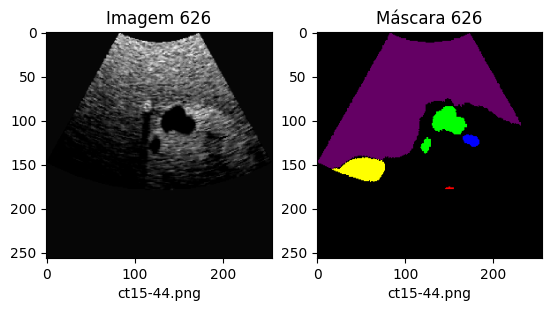

In [ ]:
# Verificando dataset dividido
idx = 626

#imagem
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx], cmap='gray')
plt.title(f"Imagem {idx}")
plt.xlabel(all_imgname[idx])

#máscara
plt.subplot(1, 2, 2)
plt.imshow(onehot_to_rgb(to_categorical(y_train[idx], num_classes = 9), dictCores))
plt.title(f"Máscara {idx}")
plt.xlabel(all_maskname[idx])

plt.show()

**Balanceando as classes**

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train.flatten())  # Flatten y_train to 1D

print("Os pesos das classes são:", class_weights)
#dicionário com pesos das classes para balanceamento
class_weights = {
    class_weights[0]: 0,
    class_weights[1]: 1,
    class_weights[2]: 2,
    class_weights[3]: 3,
    class_weights[4]: 4,
    class_weights[5]: 5,
    class_weights[6]: 6,
    class_weights[7]: 7,
    class_weights[8]: 8
}

Os pesos das classes são: [1.33613583e-01 9.49245410e-01 4.97438956e+01 2.72413430e+01
 6.13989077e+00 1.34157296e+01 3.94479946e+01 7.19208821e+00
 2.73934015e+02]


In [ ]:
from sklearn.utils import class_weight

class_weights_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}




\A classe 02 (fígado, roxo) era a classe predominante depois do preto, e seu peso foi significatiamente reduzido em relação aos demais

### **salvando o dataset**
 pq o collab ta colapsando de tanta coisa na RAM

In [ ]:
def save_dataset(X_train, X_val, X_test, y_train, y_val, y_test, save_dir="dataset"):
    os.makedirs(save_dir, exist_ok=True)

    np.save(os.path.join(save_dir, "X_train.npy"), X_train)
    np.save(os.path.join(save_dir, "X_val.npy"), X_val)
    np.save(os.path.join(save_dir, "X_test.npy"), X_test)
    np.save(os.path.join(save_dir, "y_train.npy"), y_train)
    np.save(os.path.join(save_dir, "y_val.npy"), y_val)
    np.save(os.path.join(save_dir, "y_test.npy"), y_test)

    print(f"Dataset salvo em {save_dir}")

def load_dataset(save_dir="dataset"):

    X_train = np.load(os.path.join(save_dir, "X_train.npy"))
    X_val = np.load(os.path.join(save_dir, "X_val.npy"))
    X_test = np.load(os.path.join(save_dir, "X_test.npy"))
    y_train = np.load(os.path.join(save_dir, "y_train.npy"))
    y_val = np.load(os.path.join(save_dir, "y_val.npy"))
    y_test = np.load(os.path.join(save_dir, "y_test.npy"))

    print(f"Dataset carregado de {save_dir}")
    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
# Salvando os dados
save_dataset(X_train, X_val, X_test, y_train, y_val, y_test, save_dir = "/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal")

Dataset salvo em /content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Dataset_UltrassomAbdominal


# *Treinamento*

In [ ]:
# Carregar os dados
X_train, X_val, X_test, y_train, y_val, y_test = load_dataset(save_dir="/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal")

Dataset carregado de /content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal


In [ ]:
y_train_cat = to_categorical(y_train, num_classes = 9)
y_val_cat = to_categorical(y_val, num_classes = 9)

*to_categorical está fazendo a RAM do colab estourar.. vou usar a sparse_categorical_crossentropy para compilar o modelo, e usar os pixels com os rótulos inteiros.*

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=15,            # Rotação aleatória de até 15 graus
    width_shift_range=0.3,        # Translação horizontal de até 30%
    height_shift_range=0.3,       # Translação vertical de até 30%
    shear_range=5,                # Cisalhamento de até 5%
    horizontal_flip=True,         # Flip horizontal
    vertical_flip=True,           # Flip vertical
    fill_mode='nearest',          # Preenchimento de regiões em branco após transformação
    brightness_range=[0.9, 1.1],  # Ajuste aleatório de brilho (80% a 120% do valor original)
    )

'''Mesmas transformações para as máscaras, exceto o brilho
para não afetar os valores das classes'''

mask_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
    )


#ajustando os geradores para as imagens
image_gen.fit(X_train, augment=True)
mask_gen.fit(y_train, augment=True)

# Instanciando os geradores para mascaras e imagens
image_generator = image_gen.flow(X_train, batch_size=32, seed=42)
mask_generator = mask_gen.flow(y_train, batch_size=32
, seed=42)


# Combinando os geradores para gerar lotes com as mesmas transformações
train_generator = zip(image_generator, mask_generator)

def augmenteixons():
    for img, mask in train_generator:
        yield img, mask

In [ ]:
#treinamento sem augmentation

model_name = 'Aug02'
arquivo_modelo = f'/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/modelo_{model_name}.keras' # .h não é mais aceito
arquivo_modelo_json = f'/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/modelo_{model_name}.json'

history = model.fit(X_train, y_train,
                    batch_size=16,
                    verbose=1,
                    epochs = 100,
                    validation_data=(X_test, y_test),
                    callbacks=[lr_reducer, early_stopper, checkpointer],
                    shuffle=False)


NameError: name 'lr_reducer' is not defined

In [ ]:
#Treinamento com augmentation

model_name = 'Aug02'
arquivo_modelo = f'/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/modelo_{model_name}.keras' # .h não é mais aceito
arquivo_modelo_json = f'/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/modelo_{model_name}.json'


history = model.fit(augmenteixons(),
                    steps_per_epoch=len(X_train) // 32,
                    verbose=1,
                    epochs = 100,
                    validation_data=(X_val, y_val),
                    callbacks=[ checkpointer],
                    shuffle=False)

NameError: name 'augmenteixons' is not defined

##Avaliação

In [ ]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy is = ", (acc * 100.0), "%")

##Plota a loss e accuracy de treino e validação a acda época
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = .history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - accuracy: 0.9345 - loss: 0.2465
Accuracy is =  93.63752603530884 %


TypeError: 'History' object is not subscriptable

# Testes

In [ ]:
model = load_model(f'/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/modelo_{model_name}.keras')

In [ ]:
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (93, 256, 256, 1)
y_test shape: (93, 256, 256, 1)
X_val shape: (125, 256, 256, 1)
y_val shape: (125, 256, 256, 1)


In [ ]:
#predição do conjunto de teste
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred axis=3)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [ ]:
#avaliando pela metrica "intersection over union" no conjunto de teste
from keras.metrics import MeanIoU
n_classes = 9
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)

print("Mean IoU TESTE =", IOU_keras.result().numpy())


Mean IoU TESTE = 0.3237319


pouca diferença

In [ ]:
y_pred.shape

(93, 256, 256, 9)

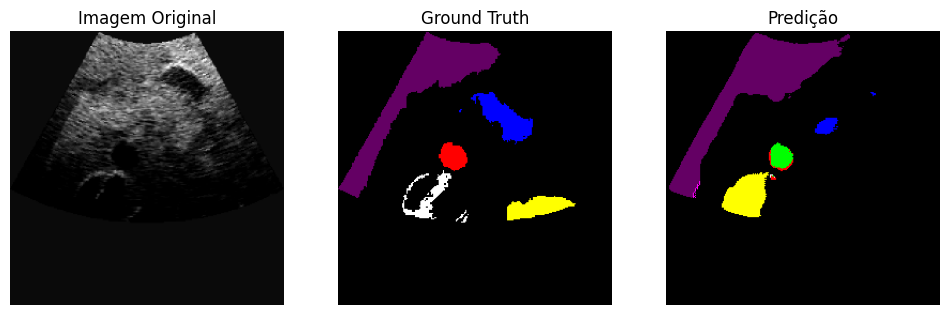

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dictCores = gen_dict_cores()

# Seleciona um índice aleatório do conjunto de teste
random_idx = np.random.randint(0, len(X_test))

# Seleciona a imagem, a máscara e a predição correspondentes
img = X_test[random_idx]
mask = y_test[random_idx]
pred = y_pred[random_idx]

# Mostra a imagem original, a máscara e a predição
plt.figure(figsize=(12, 4))

# Imagem original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Imagem Original")
plt.axis('off')

# Máscara
plt.subplot(1, 3, 2)
plt.imshow(onehot_to_rgb(to_categorical(mask, num_classes = 9), dictCores))
plt.title("Ground Truth")
plt.axis('off')
#plt.xlabel(all_imagename[random_idx])

# Predição
plt.subplot(1, 3, 3)
plt.imshow(onehot_to_rgb(pred, dictCores), cmap='gray')
plt.title("Predição")
plt.axis('off')

plt.show()


**Salvando todas as predições:**

In [ ]:
# Diretório para salvar os plots
output_dir = "/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Testes/Teste5"
os.makedirs(output_dir, exist_ok=True)  # Cria o diretório, se não existir

dictCores = gen_dict_cores()

# Itera sobre todo o conjunto de teste
for idx in range(len(X_test)):
    # Seleciona a imagem, a máscara e a predição correspondentes
    img = X_test[idx]
    mask = y_test[idx]
    pred = y_pred[idx]

    # Cria o plot
    plt.figure(figsize=(12, 4))

    # Imagem original
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Imagem Original")
    plt.axis('off')

    # Máscara
    plt.subplot(1, 3, 2)
    plt.imshow(onehot_to_rgb(to_categorical(mask, num_classes=9), dictCores))
    plt.title("Ground Truth")
    plt.axis('off')

    # Predição
    plt.subplot(1, 3, 3)
    plt.imshow(onehot_to_rgb(pred, dictCores), cmap='gray')
    plt.title("Predição")
    plt.axis('off')

    # Salva o plot no diretório
    output_path = os.path.join(output_dir, f"plot_{idx}.png")
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

print(f"Todas as imagens foram salvas em: {output_dir}")


Todas as imagens foram salvas em: /content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Testes/Teste4


In [ ]:
#com imagem real
caminhoreal = '/content/drive/MyDrive/Colab Notebooks/Segementação_Abdominal/Dataset_UltrassomAbdominal/abdominal_US/abdominal_US/RUS/images/test/a44.jpg'
img = cv2.imread(caminhoreal, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256,256))

img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=3)

In [ ]:
img.shape

(1, 256, 256, 1)

In [ ]:
y_pred=model.predict(img)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


In [ ]:
y_pred.shape

(1, 256, 256, 9)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


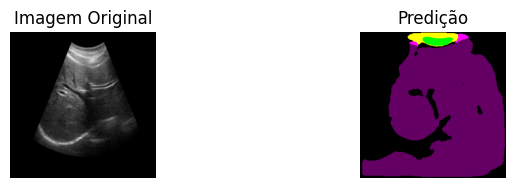

In [ ]:
# Imagem original
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img,axis = 0), cmap='gray') # img is already squeezed
plt.title("Imagem Original")
plt.axis('off')


# Predição
plt.subplot(1, 3, 3)

predicted_image = onehot_to_rgb(model.predict(img), dictCores)
predicted_image = np.squeeze(predicted_image, axis=0)
plt.imshow(predicted_image, cmap='gray')
plt.title("Predição")
plt.axis('off')

plt.show()

In [ ]:
!pip freeze > requirements.txt